### Customer Segmentation - Feature Scaling, Modeling, & Evaluation

In [17]:
# Imports and Setting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
import os
import json
from sklearn.neighbors import NearestNeighbors
from math import pi
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Metrics
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
# Load processed data with all features

df = pd.read_csv('../data/processed/Wholesale_customers_data_with_features.csv')

print(f"\nDataset loaded: {df.shape[0]} customers, {df.shape[1]} features")
print(f"Available columns: {len(df.columns)} total")
print(f"First few columns: {df.columns[:10].tolist()}")

# Define feature groups
numerical_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
categorical_cols = ['Channel', 'Region']
log_cols = [f'{col}_Log' for col in numerical_cols]
pct_cols = [f'{col}_Pct' for col in numerical_cols]

print(f"\nOriginal numerical features: {numerical_cols}")
print(f"Categorical features: {categorical_cols}")
print(f"Log-transformed features: {log_cols}")
print(f"Percentage features: {pct_cols}")


Dataset loaded: 440 customers, 32 features
Available columns: 32 total
First few columns: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen', 'Total_Spend', 'Mahalanobis_Distance']

Original numerical features: ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
Categorical features: ['Channel', 'Region']
Log-transformed features: ['Fresh_Log', 'Milk_Log', 'Grocery_Log', 'Frozen_Log', 'Detergents_Paper_Log', 'Delicassen_Log']
Percentage features: ['Fresh_Pct', 'Milk_Pct', 'Grocery_Pct', 'Frozen_Pct', 'Detergents_Paper_Pct', 'Delicassen_Pct']



FEATURE SELECTION

We have three options for features:
  Option 1: Original features (Fresh, Milk, etc.) - need log transform + scaling
  Option 2: Pre-computed log features (Fresh_Log, etc.) - only need scaling
  Option 3: Percentage features (Fresh_Pct, etc.) - already relative, need scaling

 Using Option 2: Pre-computed log-transformed features

Log-transformed features loaded: (440, 6)

Statistics of log-transformed features:
      Fresh_Log   Milk_Log  Grocery_Log  Frozen_Log  Detergents_Paper_Log  \
mean   8.732813   8.121615     8.442205    7.303128              6.791781   
std    1.470618   1.080635     1.111523    1.281888              1.709519   
min    1.386294   4.025352     1.386294    3.258097              1.386294   
max   11.627610  11.205027    11.437997   11.016496             10.617123   

      Delicassen_Log  
mean        6.671094  
std         1.293960  
min         1.386294  
max        10.777789  


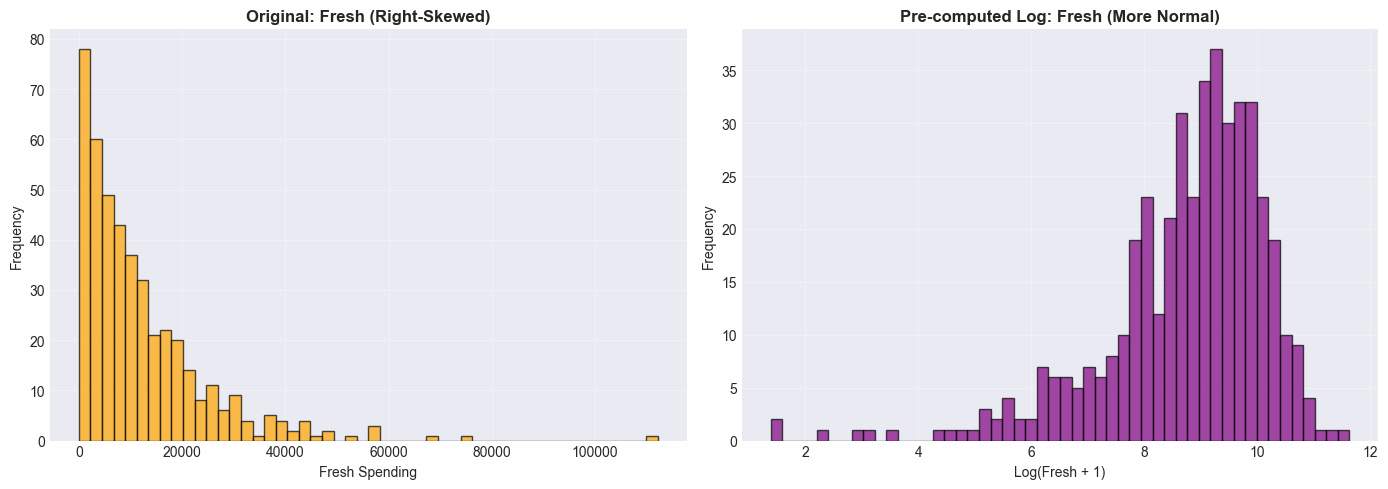


COMPARING SCALING METHODS

StandardScaler:
             Fresh          Milk       Grocery        Frozen  \
mean -1.009294e-17  9.366245e-16  5.329071e-16  2.745279e-16   
std   1.001138e+00  1.001138e+00  1.001138e+00  1.001138e+00   
min  -5.001217e+00 -3.794924e+00 -6.355190e+00 -3.159118e+00   
max   1.970662e+00  2.856582e+00  2.698281e+00  2.900093e+00   

      Detergents_Paper    Delicassen  
mean     -6.297992e-16 -3.229740e-17  
std       1.001138e+00  1.001138e+00  
min      -3.165591e+00 -4.088856e+00  
max       2.240218e+00  3.177354e+00  

RobustScaler:
         Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
mean -0.186879 -0.048427 -0.015675 -0.017836          0.031418   -0.135694
std   0.870835  0.699446  0.695194  0.819018          0.627898    0.866710
min  -4.537163 -2.699755 -4.428744 -2.602267         -1.953990   -3.675516
max   1.527292  1.947327  1.858022  2.354691          1.436447    2.615019

MinMaxScaler:
         Fresh      Milk   Grocery 

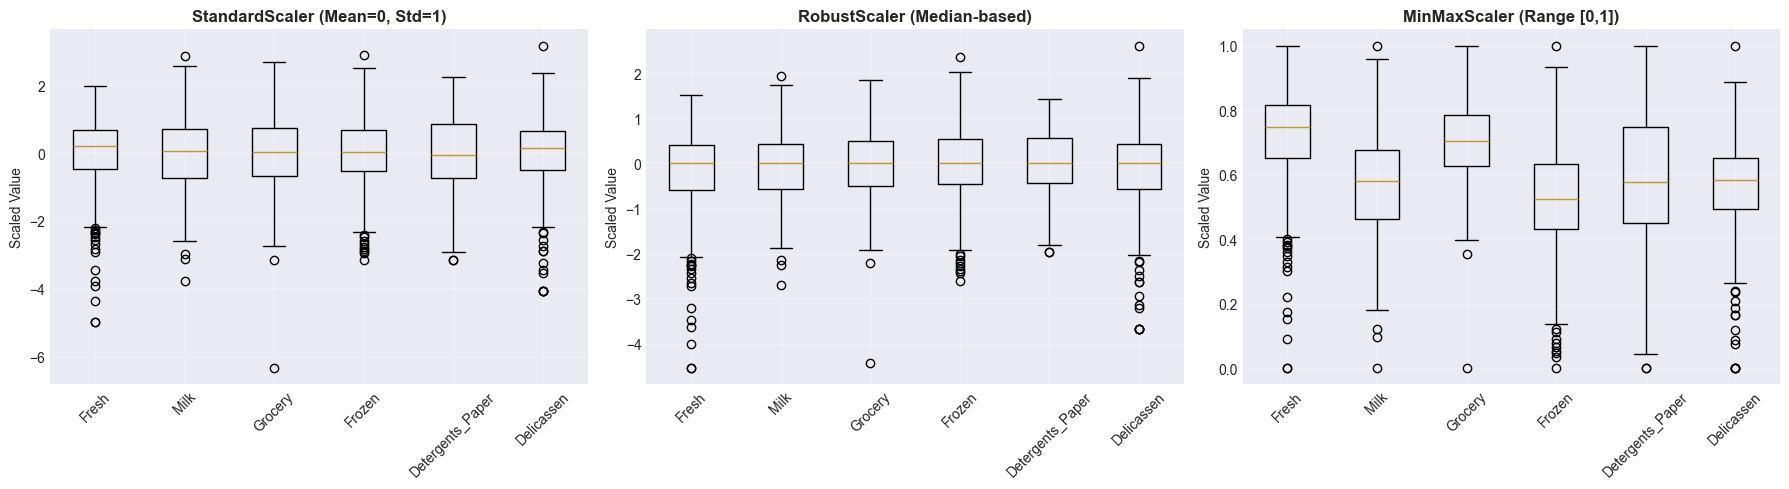


Final scaled data shape: (440, 6)


In [33]:
# Feature Scaling

# Feature Selection
print("\nFEATURE SELECTION")

print("\nWe have three options for features:")
print("  Option 1: Original features (Fresh, Milk, etc.) - need log transform + scaling")
print("  Option 2: Pre-computed log features (Fresh_Log, etc.) - only need scaling")
print("  Option 3: Percentage features (Fresh_Pct, etc.) - already relative, need scaling")
print("\n Using Option 2: Pre-computed log-transformed features")

# Use pre-computed log features
X_log = df[log_cols].copy()

print(f"\nLog-transformed features loaded: {X_log.shape}")
print("\nStatistics of log-transformed features:")
print(X_log.describe().loc[['mean', 'std', 'min', 'max']])

# Quick comparison visualization
X_original = df[numerical_cols].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(X_original['Fresh'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0].set_title('Original: Fresh (Right-Skewed)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Fresh Spending')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].hist(X_log['Fresh_Log'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1].set_title('Pre-computed Log: Fresh (More Normal)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Log(Fresh + 1)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/log_transform_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare Scaling Methods
print("\nCOMPARING SCALING METHODS")

scaler_standard = StandardScaler()
scaler_robust = RobustScaler()
scaler_minmax = MinMaxScaler()

X_standard = scaler_standard.fit_transform(X_log)
X_robust = scaler_robust.fit_transform(X_log)
X_minmax = scaler_minmax.fit_transform(X_log)

X_standard_df = pd.DataFrame(X_standard, columns=numerical_cols)
X_robust_df = pd.DataFrame(X_robust, columns=numerical_cols)
X_minmax_df = pd.DataFrame(X_minmax, columns=numerical_cols)

print("\nStandardScaler:")
print(X_standard_df.describe().loc[['mean', 'std', 'min', 'max']])
print("\nRobustScaler:")
print(X_robust_df.describe().loc[['mean', 'std', 'min', 'max']])
print("\nMinMaxScaler:")
print(X_minmax_df.describe().loc[['mean', 'std', 'min', 'max']])

# Visualize scaling comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].boxplot([X_standard_df[col] for col in numerical_cols], labels=numerical_cols)
axes[0].set_title('StandardScaler (Mean=0, Std=1)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Scaled Value')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

axes[1].boxplot([X_robust_df[col] for col in numerical_cols], labels=numerical_cols)
axes[1].set_title('RobustScaler (Median-based)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Scaled Value')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

axes[2].boxplot([X_minmax_df[col] for col in numerical_cols], labels=numerical_cols)
axes[2].set_title('MinMaxScaler (Range [0,1])', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Scaled Value')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/scale_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Use RobustScaler as final choice
X_scaled = X_robust

print(f"\nFinal scaled data shape: {X_scaled.shape}")

DETERMINING OPTIMAL NUMBER OF CLUSTERS

ELBOW METHOD


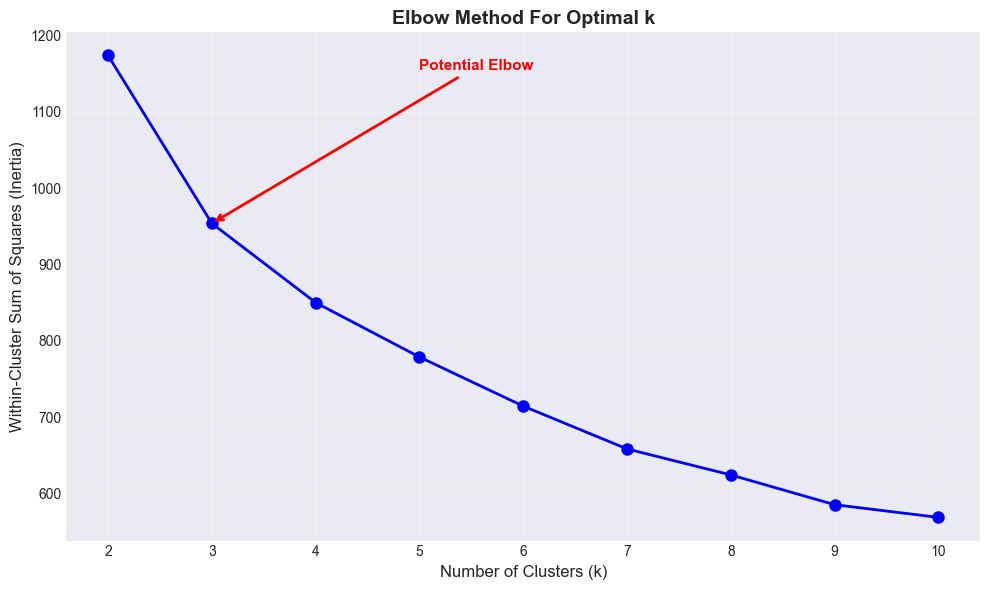


Inertia values:
  k=2: 1173.64
  k=3: 953.93
  k=4: 850.22
  k=5: 779.02
  k=6: 714.74
  k=7: 658.74
  k=8: 624.71
  k=9: 585.78
  k=10: 569.15

SILHOUETTE ANALYSIS


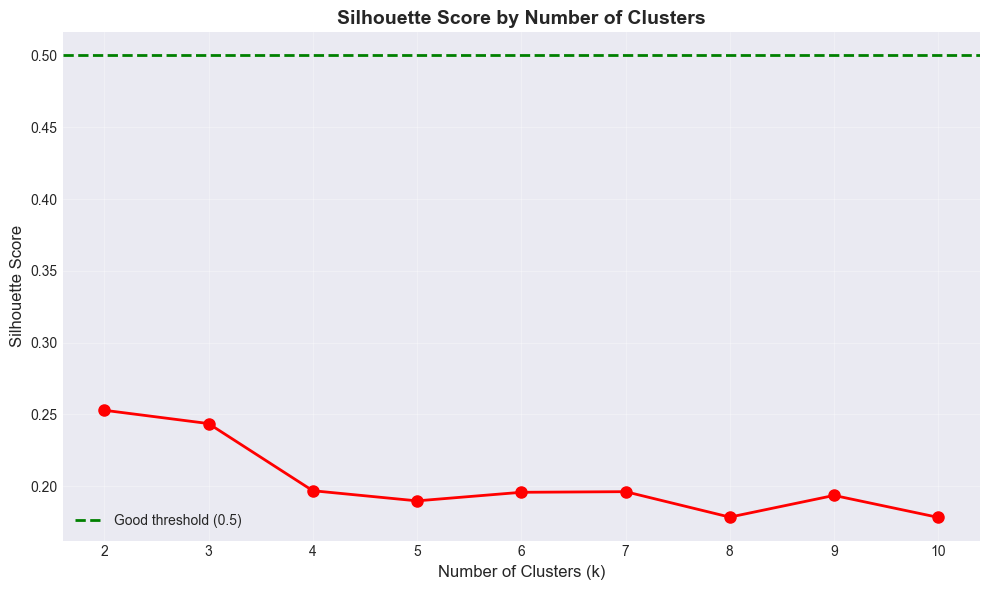


Silhouette Scores:
  k=2: 0.2529
  k=3: 0.2436
  k=4: 0.1969
  k=5: 0.1898
  k=6: 0.1958
  k=7: 0.1962
  k=8: 0.1785
  k=9: 0.1936
  k=10: 0.1783

 Best k based on Silhouette Score: 2 (score: 0.2529)

DENDROGRAM (HIERARCHICAL CLUSTERING)


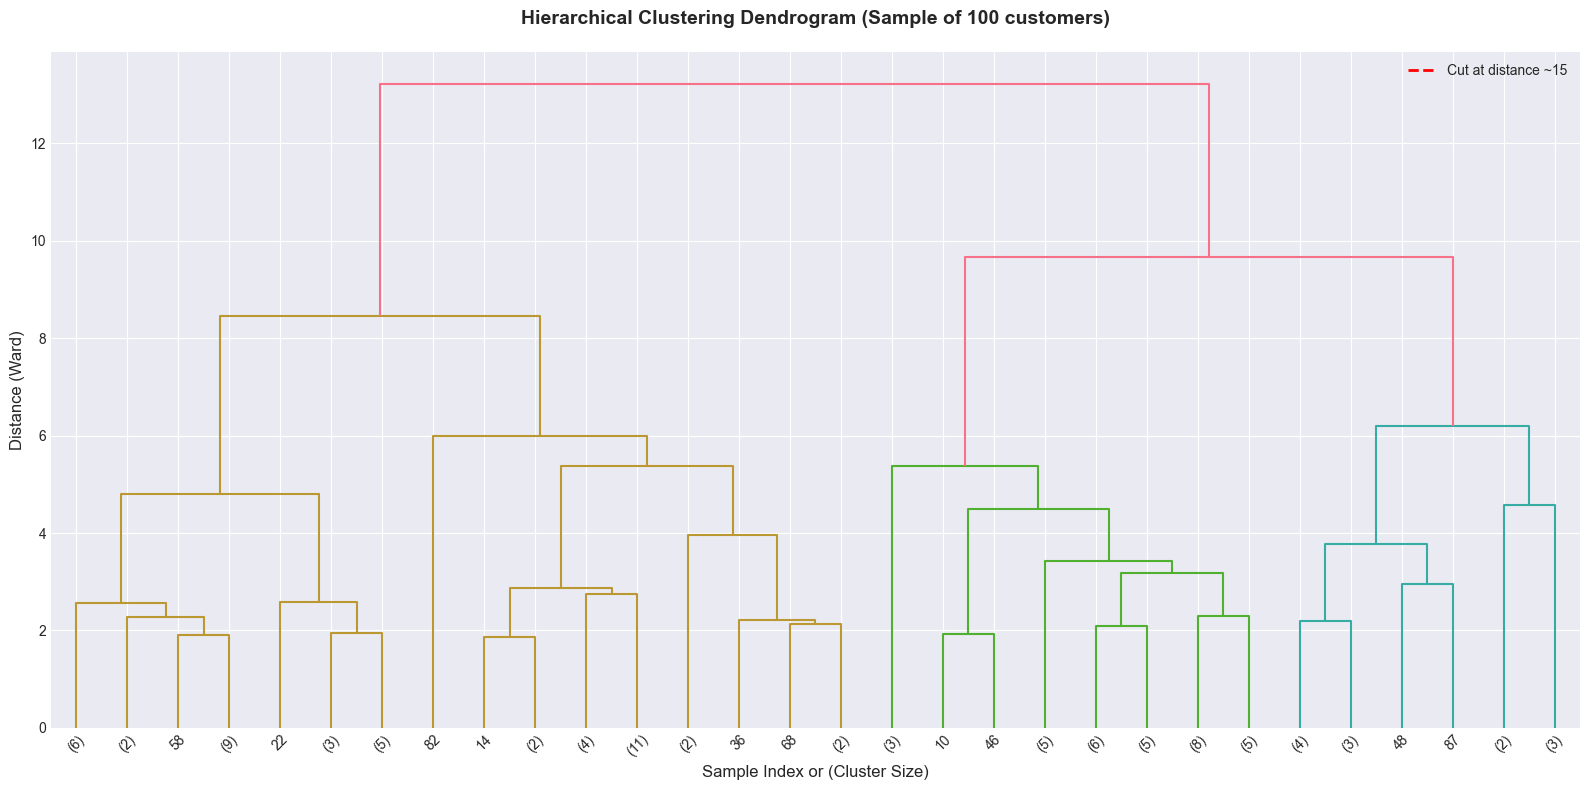


Dendrogram suggests 3-4 main clusters

K-DISTANCE PLOT FOR DBSCAN EPSILON SELECTION


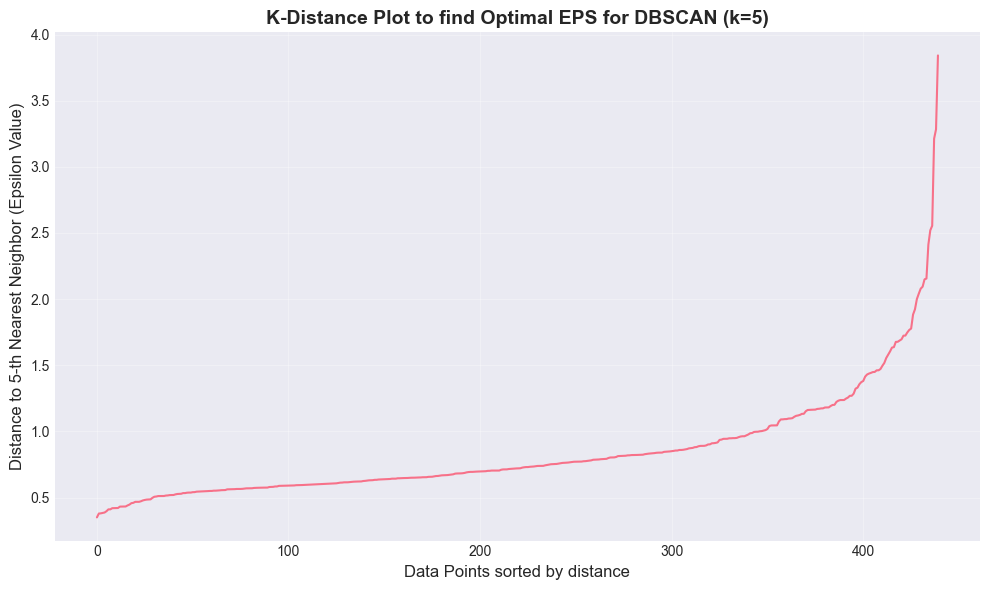

OPTIMAL k SUMMARY

Method 1: Elbow Method → k = 3-4
Method 2: Silhouette Score → k = 2
Method 3: Dendrogram → k = 3-4

 RECOMMENDATION: Test k = 3, 4, 5 and compare


In [34]:

print("DETERMINING OPTIMAL NUMBER OF CLUSTERS")

# Elbow Method
print("\nELBOW METHOD")

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.title('Elbow Method For Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.annotate('Potential Elbow', xy=(3, inertias[1]), xytext=(5, inertias[1] + 200),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, color='red', fontweight='bold')
plt.tight_layout()
plt.savefig('../results/elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInertia values:")
for k, inertia in zip(K_range, inertias):
    print(f"  k={k}: {inertia:.2f}")

# Silhouette Analysis
print("\nSILHOUETTE ANALYSIS")

silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score by Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.axhline(y=0.5, color='g', linestyle='--', label='Good threshold (0.5)', linewidth=2)
plt.legend()
plt.tight_layout()
plt.savefig('../results/silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSilhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"  k={k}: {score:.4f}")

best_k_silhouette = K_range[np.argmax(silhouette_scores)]
print(f"\n Best k based on Silhouette Score: {best_k_silhouette} (score: {max(silhouette_scores):.4f})")

#Dendrogram
print("\nDENDROGRAM (HIERARCHICAL CLUSTERING)")

sample_size = min(100, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

plt.figure(figsize=(16, 8))
linkage_matrix = linkage(X_sample, method='ward')
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Sample of 100 customers)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance (Ward)', fontsize=12)
plt.axhline(y=15, color='r', linestyle='--', label='Cut at distance ~15', linewidth=2)
plt.legend()
plt.tight_layout()
plt.savefig('../results/dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDendrogram suggests 3-4 main clusters")

# K-Distance Plot for DBSCAN
print("\nK-DISTANCE PLOT FOR DBSCAN EPSILON SELECTION")
k = 5

# Fit the NearestNeighbors model to scaled data
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)

# Calculate the distances to the k-th nearest neighbor for every point
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sorting the distances in ascending order
distances = np.sort(distances[:, k-1], axis=0)

# Plot the sorted distances
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("K-Distance Plot to find Optimal EPS for DBSCAN (k=5)", fontsize=14, fontweight='bold')
plt.ylabel(f"Distance to {k}-th Nearest Neighbor (Epsilon Value)", fontsize=12)
plt.xlabel("Data Points sorted by distance", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/k_distance_plot_dbscan.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary
print("OPTIMAL k SUMMARY")
print("\nMethod 1: Elbow Method → k = 3-4")
print(f"Method 2: Silhouette Score → k = {best_k_silhouette}")
print("Method 3: Dendrogram → k = 3-4")
print("\n RECOMMENDATION: Test k = 3, 4, 5 and compare")

#### K-Means Clustering Model

In [7]:
# K-Means Clustering
print("\nK-MEANS CLUSTERING")

kmeans_models = {}
kmeans_results = []

for k in [3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)
    
    kmeans_models[k] = {
        'model': kmeans,
        'labels': labels,
        'silhouette': sil_score,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score
    }
    
    kmeans_results.append({
        'Algorithm': 'K-Means',
        'n_clusters': k,
        'Silhouette': sil_score,
        'Davies-Bouldin': db_score,
        'Calinski-Harabasz': ch_score
    })
    
    print(f"\nK-Means (k={k}):")
    print(f"  Silhouette Score: {sil_score:.4f}")
    print(f"  Davies-Bouldin Index: {db_score:.4f}")
    print(f"  Calinski-Harabasz Score: {ch_score:.2f}")

print("\nK-Means models trained for k=3, 4, 5")


K-MEANS CLUSTERING

K-Means (k=3):
  Silhouette Score: 0.2447
  Davies-Bouldin Index: 1.3200
  Calinski-Harabasz Score: 138.18

K-Means (k=4):
  Silhouette Score: 0.2017
  Davies-Bouldin Index: 1.3836
  Calinski-Harabasz Score: 121.02

K-Means (k=5):
  Silhouette Score: 0.1898
  Davies-Bouldin Index: 1.4432
  Calinski-Harabasz Score: 108.63

K-Means models trained for k=3, 4, 5


#### Hierarchical Clustering

In [9]:
# Hierarchical Clustering
print("\nHIERARCHICAL CLUSTERING")

hierarchical_models = {}
hierarchical_results = []

for k in [3, 4, 5]:
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hierarchical.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)
    
    hierarchical_models[k] = {
        'model': hierarchical,
        'labels': labels,
        'silhouette': sil_score,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score
    }
    
    hierarchical_results.append({
        'Algorithm': 'Hierarchical',
        'n_clusters': k,
        'Silhouette': sil_score,
        'Davies-Bouldin': db_score,
        'Calinski-Harabasz': ch_score
    })
    
    print(f"\nHierarchical (k={k}):")
    print(f"  Silhouette Score: {sil_score:.4f}")
    print(f"  Davies-Bouldin Index: {db_score:.4f}")
    print(f"  Calinski-Harabasz Score: {ch_score:.2f}")

print("\n Hierarchical models trained for k= 3, 4, 5")


HIERARCHICAL CLUSTERING

Hierarchical (k=3):
  Silhouette Score: 0.2431
  Davies-Bouldin Index: 1.3921
  Calinski-Harabasz Score: 112.78

Hierarchical (k=4):
  Silhouette Score: 0.1611
  Davies-Bouldin Index: 1.5910
  Calinski-Harabasz Score: 100.12

Hierarchical (k=5):
  Silhouette Score: 0.1383
  Davies-Bouldin Index: 1.5863
  Calinski-Harabasz Score: 91.76

 Hierarchical models trained for k= 3, 4, 5


#### DBSCAN

In [31]:
# DBSCAN
print("\nDBSCAN CLUSTERING")

dbscan_results = []
eps_values = [0.8, 0.9, 1.0, 1.1, 1.2]

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"\nDBSCAN (eps={eps}):")
    print(f"  Clusters found: {n_clusters}")
    print(f"  Noise points: {n_noise} ({n_noise/len(labels)*100:.1f}%)")
    
    if n_clusters >= 2 and n_noise < len(labels) * 0.5:
        mask = labels != -1
        if mask.sum() > 0:
            sil_score = silhouette_score(X_scaled[mask], labels[mask])
            print(f"  Silhouette Score: {sil_score:.4f}")
            
            dbscan_results.append({
                'Algorithm': 'DBSCAN',
                'eps': eps,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_pct': f"{n_noise/len(labels)*100:.1f}%",
                'Silhouette': sil_score
            })
    else:
        print(f"  (Too few clusters or too much noise)")

if dbscan_results:
    print("\nDBSCAN Summary:")
    dbscan_df = pd.DataFrame(dbscan_results)
    print(dbscan_df.to_string(index=False))
else:
    print("\nDBSCAN did not produce viable clustering results.")
    print("\nREASONS:")
    print("  1. High dimensionality (6 features) - distances become less meaningful")
    print("  2. Varying cluster densities - DBSCAN assumes uniform density")
    print("  3. No clear 'noise' points - all customers are legitimate")
    print("\nRECOMMENDATION: Using K-Means or Hierarchical clustering instead")
    print("These algorithms are better suited for customer segmentation tasks.")


DBSCAN CLUSTERING

DBSCAN (eps=0.8):
  Clusters found: 1
  Noise points: 109 (24.8%)
  (Too few clusters or too much noise)

DBSCAN (eps=0.9):
  Clusters found: 1
  Noise points: 84 (19.1%)
  (Too few clusters or too much noise)

DBSCAN (eps=1.0):
  Clusters found: 1
  Noise points: 59 (13.4%)
  (Too few clusters or too much noise)

DBSCAN (eps=1.1):
  Clusters found: 1
  Noise points: 45 (10.2%)
  (Too few clusters or too much noise)

DBSCAN (eps=1.2):
  Clusters found: 1
  Noise points: 35 (8.0%)
  (Too few clusters or too much noise)

DBSCAN did not produce viable clustering results.

REASONS:
  1. High dimensionality (6 features) - distances become less meaningful
  2. Varying cluster densities - DBSCAN assumes uniform density
  3. No clear 'noise' points - all customers are legitimate

RECOMMENDATION: Using K-Means or Hierarchical clustering instead
These algorithms are better suited for customer segmentation tasks.


#### Model Comparison & Selecting Best Model


MODEL COMPARISON

    Algorithm  n_clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz
     K-Means           3    0.244659        1.319993         138.175873
     K-Means           4    0.201693        1.383560         121.015252
     K-Means           5    0.189820        1.443177         108.630666
Hierarchical           3    0.243053        1.392057         112.784497
Hierarchical           4    0.161111        1.590964         100.122023
Hierarchical           5    0.138345        1.586350          91.763687

Metric Interpretation:
  - Silhouette Score: Higher is better (>0.5 is good)
  - Davies-Bouldin Index: Lower is better
  - Calinski-Harabasz Score: Higher is better


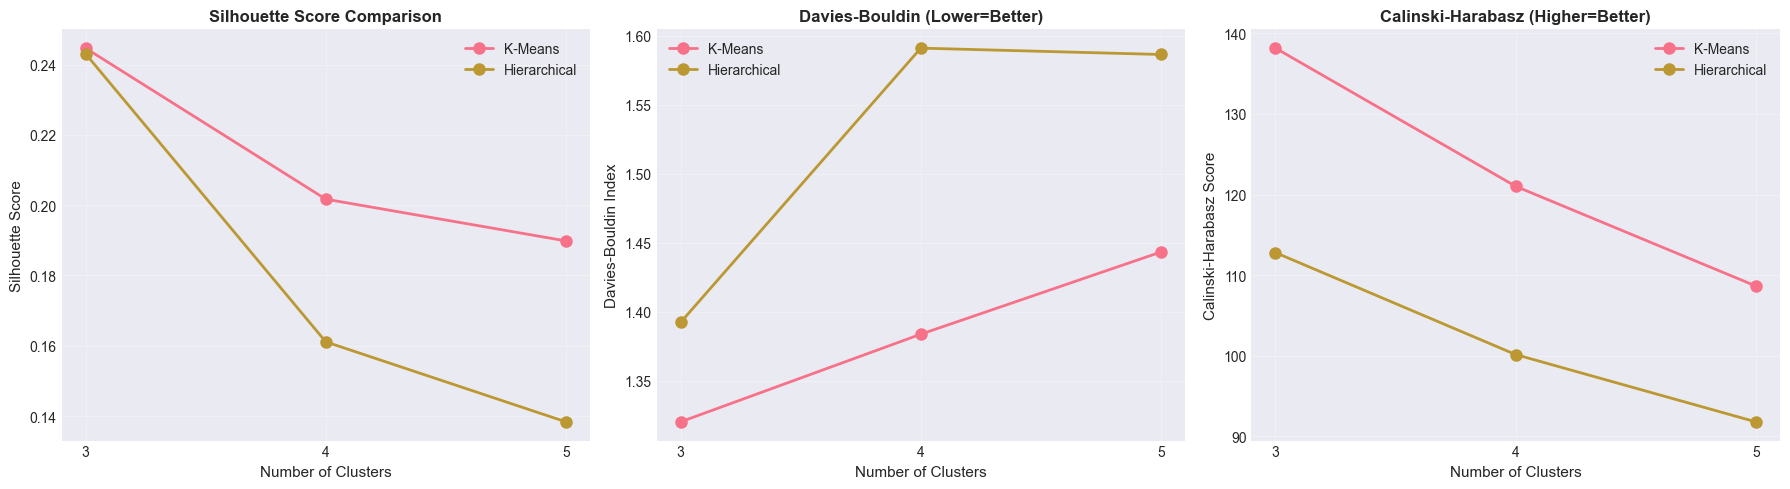


4.5 BEST MODEL SELECTION

Best Model: K-Means with k=3

Metrics:
  Silhouette Score: 0.2447
  Davies-Bouldin Index: 1.3200
  Calinski-Harabasz Score: 138.18

Cluster labels assigned to dataset

Cluster Distribution:
Cluster
0    151
1    209
2     80
Name: count, dtype: int64


In [35]:
# Model Comparison
print("\nMODEL COMPARISON")

all_results = kmeans_results + hierarchical_results
results_df = pd.DataFrame(all_results)

print("\n", results_df.to_string(index=False))
print("\nMetric Interpretation:")
print("  - Silhouette Score: Higher is better (>0.5 is good)")
print("  - Davies-Bouldin Index: Lower is better")
print("  - Calinski-Harabasz Score: Higher is better")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for algo in ['K-Means', 'Hierarchical']:
    data = results_df[results_df['Algorithm'] == algo]
    axes[0].plot(data['n_clusters'], data['Silhouette'], 'o-', 
                linewidth=2, markersize=8, label=algo)
axes[0].set_xlabel('Number of Clusters', fontsize=11)
axes[0].set_ylabel('Silhouette Score', fontsize=11)
axes[0].set_title('Silhouette Score Comparison', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([3, 4, 5])

for algo in ['K-Means', 'Hierarchical']:
    data = results_df[results_df['Algorithm'] == algo]
    axes[1].plot(data['n_clusters'], data['Davies-Bouldin'], 'o-', 
                linewidth=2, markersize=8, label=algo)
axes[1].set_xlabel('Number of Clusters', fontsize=11)
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[1].set_title('Davies-Bouldin (Lower=Better)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks([3, 4, 5])

for algo in ['K-Means', 'Hierarchical']:
    data = results_df[results_df['Algorithm'] == algo]
    axes[2].plot(data['n_clusters'], data['Calinski-Harabasz'], 'o-', 
                linewidth=2, markersize=8, label=algo)
axes[2].set_xlabel('Number of Clusters', fontsize=11)
axes[2].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[2].set_title('Calinski-Harabasz (Higher=Better)', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks([3, 4, 5])

plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#Select Best Model
print("\n4.5 BEST MODEL SELECTION")

best_idx = results_df['Silhouette'].idxmax()
best_model_info = results_df.loc[best_idx]

print(f"\nBest Model: {best_model_info['Algorithm']} with k={int(best_model_info['n_clusters'])}")
print(f"\nMetrics:")
print(f"  Silhouette Score: {best_model_info['Silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {best_model_info['Davies-Bouldin']:.4f}")
print(f"  Calinski-Harabasz Score: {best_model_info['Calinski-Harabasz']:.2f}")

best_k = int(best_model_info['n_clusters'])
if best_model_info['Algorithm'] == 'K-Means':
    best_model = kmeans_models[best_k]['model']
    best_labels = kmeans_models[best_k]['labels']
else:
    best_model = hierarchical_models[best_k]['model']
    best_labels = hierarchical_models[best_k]['labels']

df['Cluster'] = best_labels

print(f"\nCluster labels assigned to dataset")
print(f"\nCluster Distribution:")
print(df['Cluster'].value_counts().sort_index())


#### Detailed Cluster Eval

DETAILED CLUSTER EVALUATION

 DETAILED SILHOUETTE ANALYSIS


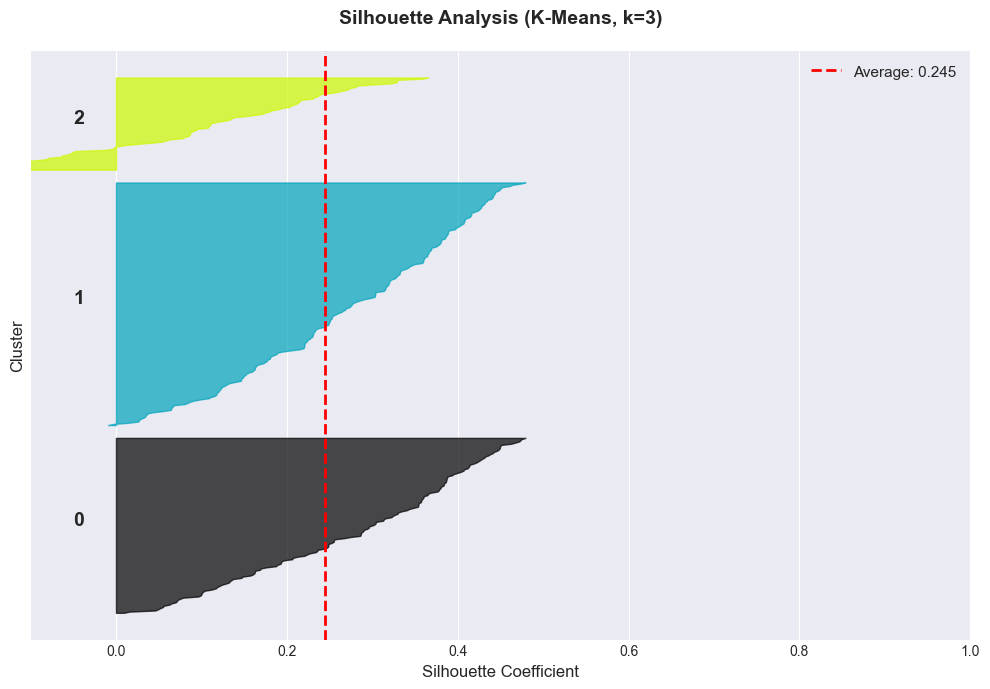

Average Silhouette Score: 0.2447

PCA VISUALIZATION
2D PCA variance explained: 69.1%
3D PCA variance explained: 82.2%


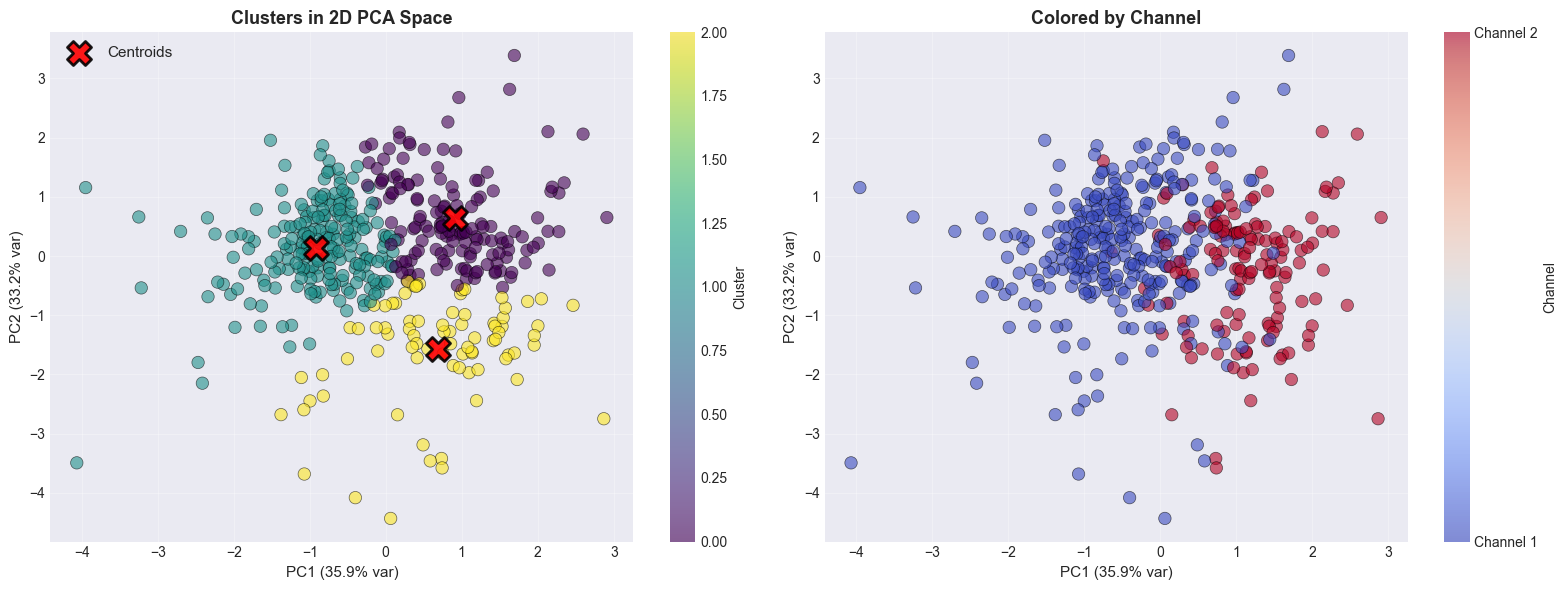

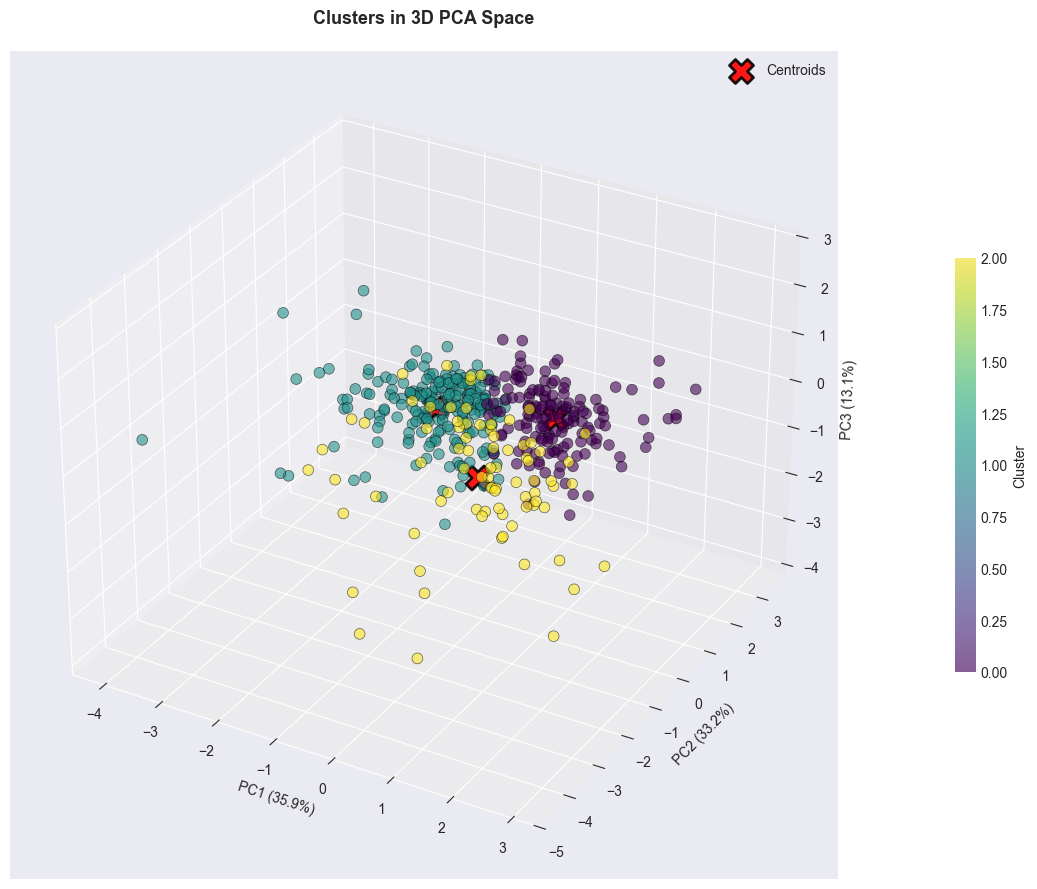

In [36]:

print("DETAILED CLUSTER EVALUATION")

# 5.1 Detailed Silhouette Analysis
print("\n DETAILED SILHOUETTE ANALYSIS")

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

silhouette_vals = silhouette_samples(X_scaled, best_labels)
avg_score = silhouette_score(X_scaled, best_labels)

y_lower = 10
for i in range(best_k):
    cluster_silhouette_vals = silhouette_vals[best_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), 
           fontsize=14, fontweight='bold')
    
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title(f'Silhouette Analysis ({best_model_info["Algorithm"]}, k={best_k})', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=avg_score, color='red', linestyle='--', linewidth=2, 
           label=f'Average: {avg_score:.3f}')
ax.legend(fontsize=11)
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
plt.tight_layout()
plt.savefig('../results/silhouette_analysis_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Average Silhouette Score: {avg_score:.4f}")

# PCA Visualization
print("\nPCA VISUALIZATION")

pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print(f"2D PCA variance explained: {pca_2d.explained_variance_ratio_.sum()*100:.1f}%")
print(f"3D PCA variance explained: {pca_3d.explained_variance_ratio_.sum()*100:.1f}%")

# 2D Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                           c=best_labels, cmap='viridis', 
                           s=80, alpha=0.6, edgecolors='black', linewidth=0.5)

if best_model_info['Algorithm'] == 'K-Means':
    centers_pca = pca_2d.transform(best_model.cluster_centers_)
    axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], 
                   c='red', s=300, alpha=0.9, marker='X', 
                   edgecolors='black', linewidth=2, label='Centroids')
    axes[0].legend(fontsize=11)

axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% var)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% var)', fontsize=11)
axes[0].set_title('Clusters in 2D PCA Space', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                           c=df['Channel'], cmap='coolwarm', 
                           s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% var)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% var)', fontsize=11)
axes[1].set_title('Colored by Channel', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Channel', ticks=[1, 2])
cbar2.set_ticklabels(['Channel 1', 'Channel 2'])

plt.tight_layout()
plt.savefig('../results/pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 3D Visualization
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                    c=best_labels, cmap='viridis', 
                    s=60, alpha=0.6, edgecolors='black', linewidth=0.5)

if best_model_info['Algorithm'] == 'K-Means':
    centers_pca_3d = pca_3d.transform(best_model.cluster_centers_)
    ax.scatter(centers_pca_3d[:, 0], centers_pca_3d[:, 1], centers_pca_3d[:, 2],
              c='red', s=300, alpha=0.9, marker='X', 
              edgecolors='black', linewidth=2, label='Centroids')
    ax.legend(fontsize=10)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10)
ax.set_title('Clusters in 3D PCA Space', fontsize=13, fontweight='bold', pad=20)
plt.colorbar(scatter, ax=ax, label='Cluster', shrink=0.5, pad=0.1)
plt.tight_layout()
plt.savefig('../results/pca_3d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


#### Cluster Profiling

CLUSTER PROFILING & BUSINESS INSIGHTS

STATISTICAL SUMMARY BY CLUSTER
                Fresh                                 Milk          \
                 mean   median           std          mean  median   
Cluster                                                              
0        16719.649007  11908.0  16131.699401  10434.894040  7108.0   
1        12195.622010   9784.0   9687.041917   1980.464115  1601.0   
2         2582.237500   1190.0   3897.275463   7009.637500  6300.5   

                            Grocery                              Frozen  \
                  std          mean   median           std         mean   
Cluster                                                                   
0        10065.070519  13224.119205   9965.0  11247.201180  4037.132450   
1         1418.477786   2490.186603   2147.0   1619.799020  3248.856459   
2         4888.653275  12265.887500  10431.0  10191.117181   787.900000   

                             Detergents_Paper             

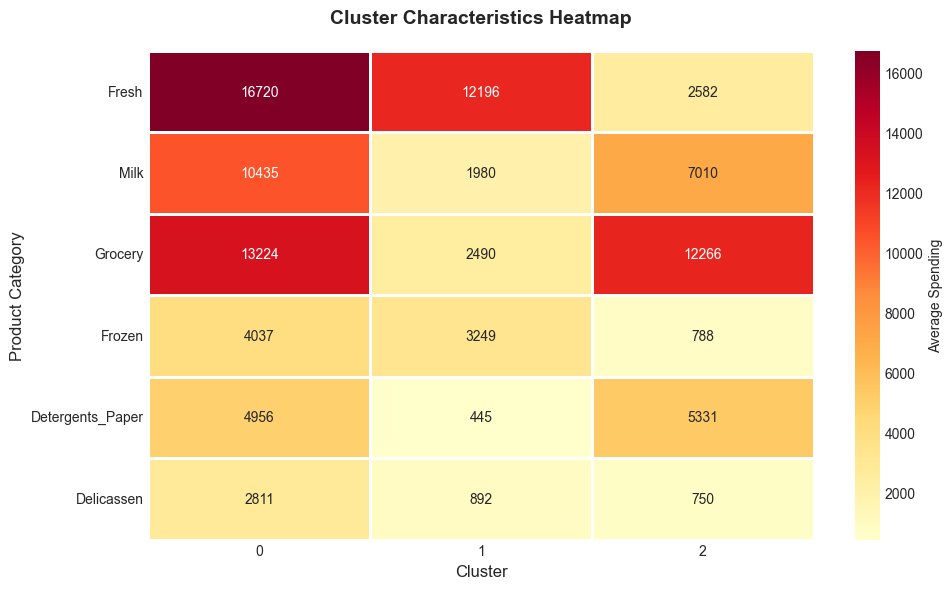


SPENDING BY CLUSTER


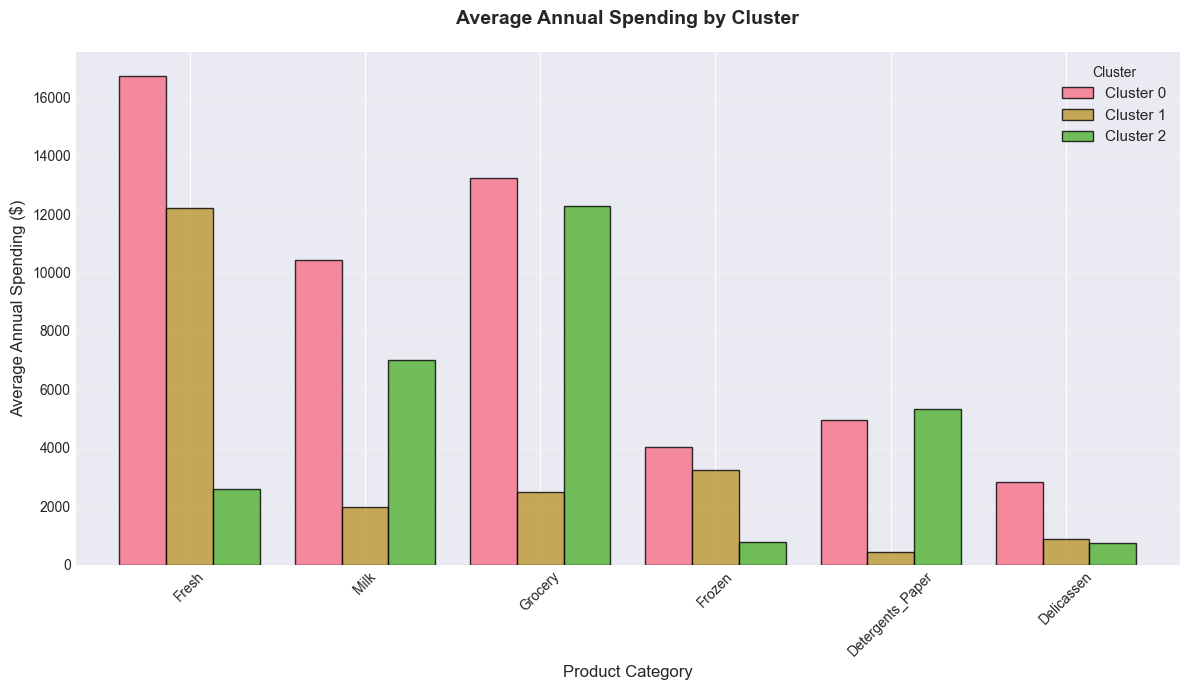


RADAR CHART - CLUSTER PROFILES


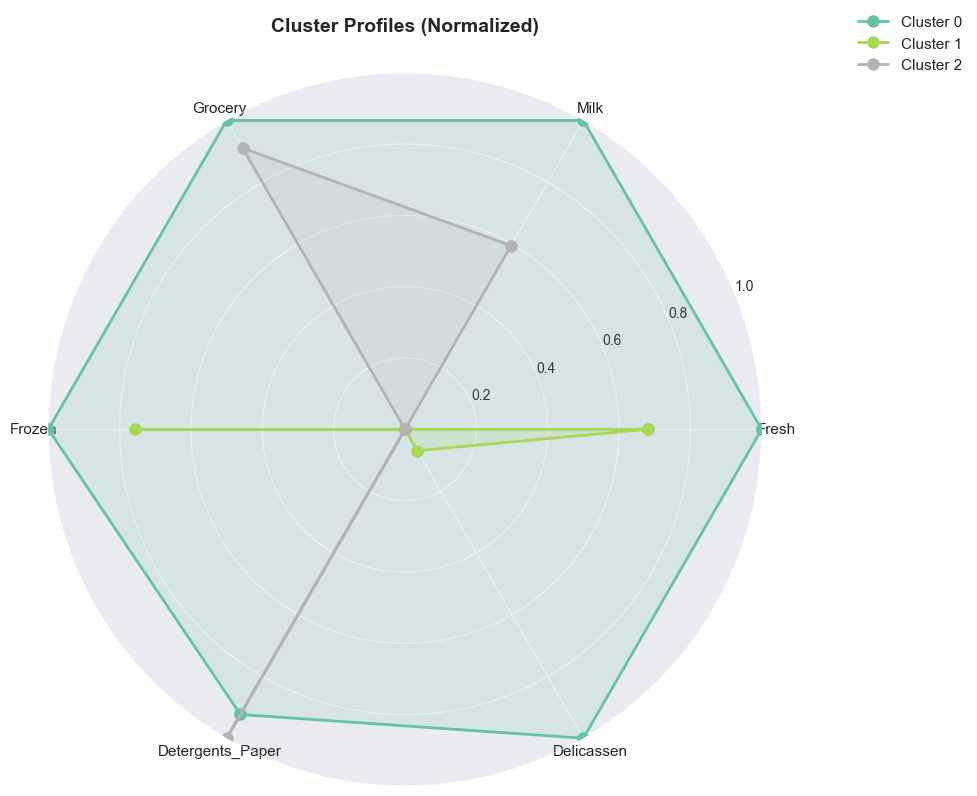


CHANNEL & REGION DISTRIBUTION BY CLUSTER


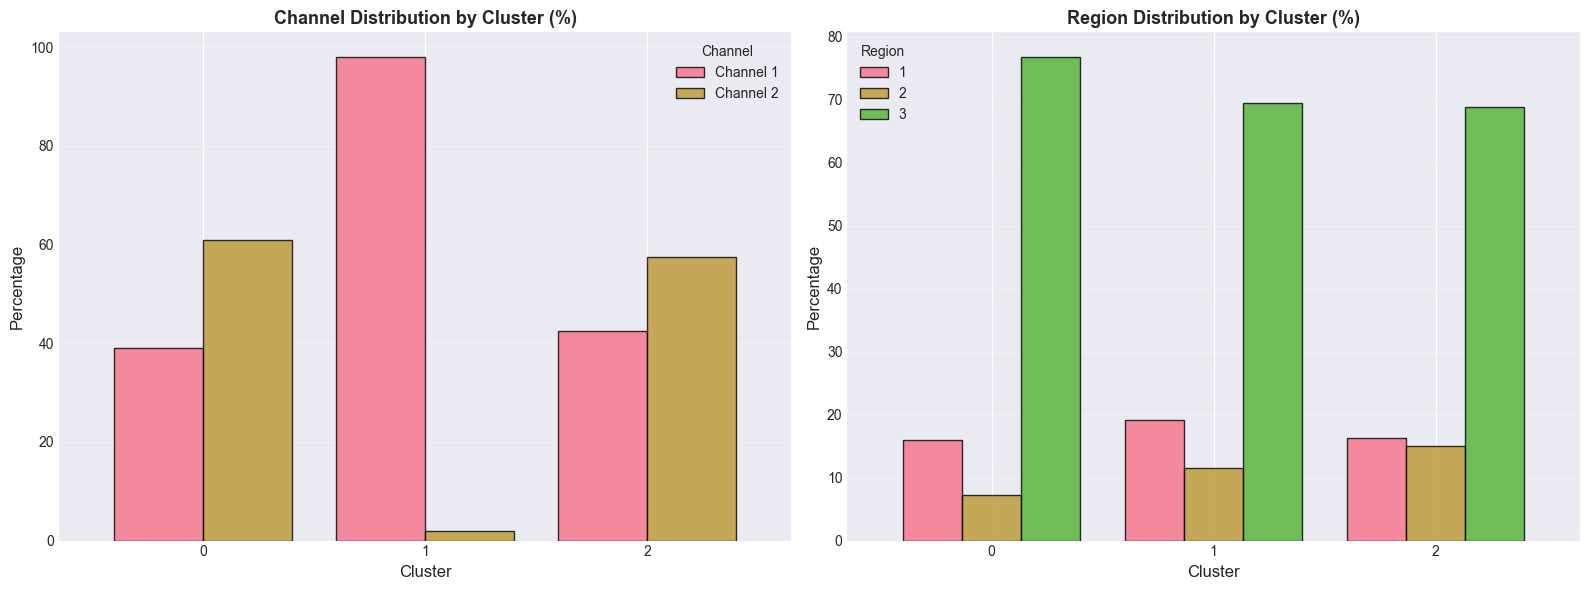


Channel Distribution (counts):
Channel    1   2
Cluster         
0         59  92
1        205   4
2         34  46

Region Distribution (counts):
Region    1   2    3
Cluster             
0        24  11  116
1        40  24  145
2        13  12   55

CLUSTER DESCRIPTIONS

CLUSTER 0
Size: 151 customers (34.3%)

Top 3 Categories:
  1. Fresh: $16,720
  2. Grocery: $13,224
  3. Milk: $10,435

Dominant Channel: Retail (60.9%)
Avg Total Annual Spending: $52,182

CLUSTER 1
Size: 209 customers (47.5%)

Top 3 Categories:
  1. Fresh: $12,196
  2. Frozen: $3,249
  3. Grocery: $2,490

Dominant Channel: Horeca (98.1%)
Avg Total Annual Spending: $21,253

CLUSTER 2
Size: 80 customers (18.2%)

Top 3 Categories:
  1. Grocery: $12,266
  2. Milk: $7,010
  3. Detergents_Paper: $5,331

Dominant Channel: Retail (57.5%)
Avg Total Annual Spending: $28,727


In [37]:
print("CLUSTER PROFILING & BUSINESS INSIGHTS")

# Statistical Summary
print("\nSTATISTICAL SUMMARY BY CLUSTER")

cluster_summary = df.groupby('Cluster')[numerical_cols].agg(['mean', 'median', 'std'])
print(cluster_summary)

print("\nCluster Sizes:")
cluster_sizes = df['Cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    percentage = (size / len(df)) * 100
    print(f"  Cluster {cluster_id}: {size} customers ({percentage:.1f}%)")

#Heatmap
print("\nCLUSTER HEATMAP")

cluster_means = df.groupby('Cluster')[numerical_cols].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Average Spending'}, linewidths=2)
plt.title('Cluster Characteristics Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.tight_layout()
plt.savefig('../results/cluster_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

#Bar Charts
print("\nSPENDING BY CLUSTER")

fig, ax = plt.subplots(figsize=(12, 7))
cluster_means.T.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', alpha=0.8)
ax.set_title('Average Annual Spending by Cluster', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Product Category', fontsize=12)
ax.set_ylabel('Average Annual Spending ($)', fontsize=12)
ax.legend(title='Cluster', labels=[f'Cluster {i}' for i in range(best_k)], fontsize=11)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../results/spending_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

#Radar Chart
print("\nRADAR CHART - CLUSTER PROFILES")

cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

categories = numerical_cols
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = plt.cm.Set2(np.linspace(0, 1, best_k))

for idx, cluster_id in enumerate(range(best_k)):
    values = cluster_means_norm.iloc[cluster_id].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}', 
            markersize=8, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_title('Cluster Profiles (Normalized)', size=14, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True)
plt.tight_layout()
plt.savefig('../results/radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

#Channel & Region Distribution
print("\nCHANNEL & REGION DISTRIBUTION BY CLUSTER")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

channel_cluster = pd.crosstab(df['Cluster'], df['Channel'], normalize='index') * 100
channel_cluster.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black', alpha=0.8)
axes[0].set_title('Channel Distribution by Cluster (%)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Percentage', fontsize=12)
axes[0].legend(title='Channel', labels=['Channel 1', 'Channel 2'])
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

region_cluster = pd.crosstab(df['Cluster'], df['Region'], normalize='index') * 100
region_cluster.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black', alpha=0.8)
axes[1].set_title('Region Distribution by Cluster (%)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Percentage', fontsize=12)
axes[1].legend(title='Region')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/channel_region_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nChannel Distribution (counts):")
print(pd.crosstab(df['Cluster'], df['Channel']))
print("\nRegion Distribution (counts):")
print(pd.crosstab(df['Cluster'], df['Region']))

#Detailed Descriptions
print("\nCLUSTER DESCRIPTIONS")

for cluster_id in range(best_k):
    cluster_data = df[df['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    cluster_pct = (cluster_size / len(df)) * 100
    
    print(f"\n{'='*100}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*100}")
    print(f"Size: {cluster_size} customers ({cluster_pct:.1f}%)")
    
    avg_spending = cluster_data[numerical_cols].mean().sort_values(ascending=False)
    print(f"\nTop 3 Categories:")
    for i, (cat, val) in enumerate(avg_spending.head(3).items(), 1):
        print(f"  {i}. {cat}: ${val:,.0f}")
    
    channel_dist = cluster_data['Channel'].value_counts()
    if len(channel_dist) > 0:
        dominant_channel = channel_dist.idxmax()
        channel_pct = (channel_dist.max() / cluster_size) * 100
        channel_name = "Horeca" if dominant_channel == 1 else "Retail"
        print(f"\nDominant Channel: {channel_name} ({channel_pct:.1f}%)")
    
    total_spending = cluster_data[numerical_cols].sum(axis=1).mean()
    print(f"Avg Total Annual Spending: ${total_spending:,.0f}")

In [22]:
# Recommendations

cluster_total_spending = df.groupby('Cluster')[numerical_cols].apply(lambda x: x.sum(axis=1).mean())
high_value = cluster_total_spending.idxmax()
low_value = cluster_total_spending.idxmin()

print(f"\nCluster {high_value} - High Value (${cluster_total_spending[high_value]:,.0f}/yr):")
print("  1. VIP loyalty program")
print("  2. Dedicated account management")
print("  3. Volume-based discounts")
print("  4. Priority service")

print(f"\nCluster {low_value} - Growth Opportunity (${cluster_total_spending[low_value]:,.0f}/yr):")
print("  1. Upselling campaigns")
print("  2. Introductory promotions")
print("  3. Product education")
print("  4. Bundle offers")


Cluster 0 - High Value ($52,182/yr):
  1. VIP loyalty program
  2. Dedicated account management
  3. Volume-based discounts
  4. Priority service

Cluster 1 - Growth Opportunity ($21,253/yr):
  1. Upselling campaigns
  2. Introductory promotions
  3. Product education
  4. Bundle offers


In [25]:
# Saving Models
model_filename = f'../models/{best_model_info["Algorithm"].lower().replace("-", "_")}_k{best_k}_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Model saved: {model_filename}")

# Save scaler
with open('../models/robust_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_robust, f)
print(f"Scaler saved: ../models/robust_scaler.pkl")

# Save clustered data
df.to_csv('../data/processed/customer_segments.csv', index=False)
print(f"Data saved: ../data/processed/customer_segments.csv")
# Save results
results_df.to_csv('../results/model_comparison.csv', index=False)
print(f"Results saved: ../results/model_comparison.csv")

# Save metadata
metadata = {
    'best_model': best_model_info['Algorithm'],
    'n_clusters': int(best_k),
    'silhouette_score': float(best_model_info['Silhouette']),
    'davies_bouldin_index': float(best_model_info['Davies-Bouldin']),
    'calinski_harabasz_score': float(best_model_info['Calinski-Harabasz']),
    'total_customers': len(df),
    'features_used': numerical_cols,
    'scaling_method': 'RobustScaler',
    'transformation': 'log1p'
}

with open('../results/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"Metadata saved: ../results/model_metadata.json")


Model saved: ../models/k_means_k3_model.pkl
Scaler saved: ../models/robust_scaler.pkl
Data saved: ../data/processed/customer_segments.csv
Results saved: ../results/model_comparison.csv
Metadata saved: ../results/model_metadata.json
